In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

companies = ['GAZP', 'SBER', 'LKOH', 'GMKN', 'MGNT',
       'TATN', 'NVTK', 'SNGS', 'PLZL', 'SNGSP',
       'PIKK', 'ROSN', 'SBERP', 'CHMF', 'NLMK',
       'IRAO', 'YNDX', 'ALRS', 'RUAL', 'MTSS',
       'MAGN', 'PHOR', 'RTKM', 'VTBR', 'TATNP',
       'TCSG', 'AGRO', 'OZON', 'AFLT', 'AFKS',
       'FEES', 'TRNFP', 'CBOM', 'VKCO', 'ENPG',
       'SGZH', 'FIVE', 'POLY', 'MOEX', 'GLTR',
       'HYDR', 'FIXP']

/tmp/ipykernel_31417/3897907851.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/Total_MOEX_hourly_with_time_df'
total_df = pd.read_csv(path)

In [3]:
data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')

/tmp/ipykernel_31417/4178699835.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data = total_df[total_df.secid == 'SBER'].drop('secid', 1)#.set_index('tradedate')


In [4]:
train_data = data[ : round(data.shape[0]*0.80) ].to_numpy()

val_data = data[ round(data.shape[0]*0.80) : ].to_numpy()

In [5]:
for i in range(data.shape[1]):
    if i == 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
    
        scaler_star = StandardScaler()
        train_series = scaler_star.fit_transform(train_series)
        val_series = scaler_star.transform(val_series)
    
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()
    
    elif i != 0:
        train_series = train_data[:,i].reshape(-1, 1)
        val_series = val_data[:,i].reshape(-1, 1)
        
        scaler = StandardScaler()
        train_series = scaler.fit_transform(train_series)
        val_series = scaler.transform(val_series)
        
        train_data[:, i] = train_series.flatten()
        val_data[:, i] = val_series.flatten()

In [28]:
train_data1 = train_data[ : round(data.shape[0]*0.51) ]
train_data2 = train_data[ round(data.shape[0]*0.60) : round(data.shape[0]*0.80) ]

In [29]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [116]:
# lookback = 104
# horizon = 1

# x_train, y_train = sample_creator(train_data, lookback, horizon)
# x_val, y_val = sample_creator(val_data, lookback, horizon)

# print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')


# train_dataset = TensorDataset(x_train, y_train)
# val_dataset  = TensorDataset(x_val, y_val)

# train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
# val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

lookback = 32
horizon = 1

x_train1, y_train1 = sample_creator(train_data1, lookback, horizon)
x_train2, y_train2 = sample_creator(train_data2, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

x_train= torch.Tensor( np.concatenate([x_train1, x_train2]) )
y_train = torch.Tensor( np.concatenate([y_train1, y_train2]) )

train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)                          


train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([5563, 32, 57]), y_train: torch.Size([5563, 1])
x_val: torch.Size([1553, 32, 57]), y_val: torch.Size([1553, 1])


In [115]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=58, d_model=512, nhead=8, num_layers=4, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.ebedder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x[:, -1, :])  
        return x    

In [10]:
# def weights_adoptation(path):
#     state_dict = torch.load(path)
#     new_state_dict = {}
#     for key in state_dict:
#         new_key = key.replace('module.','')
#         new_state_dict[new_key] = state_dict[key]
#     return new_state_dict

# path = 'WEIGHTS/(512,8,5,0.1)TRANS(ENC)(M F=TI)1D|||W=0.4636, VL=1.9381'

# new_weights = weights_adoptation(path)

# model = TransformerModel().to(device)
# model.load_state_dict(new_weights)

In [126]:
model = TransformerModel(input_dim=57, d_model=512, nhead=8, num_layers=1, dropout=0.0).to(device)

In [127]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 50
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.cpu().detach().reshape(-1,), outputs.cpu().detach().reshape(-1,))
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    #if val_loss < 0.0002:
        #torch.save(model.state_dict(), f'МОДЕЛИ/Веса для val_loss = {val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 20:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1 / 50,Train Loss: 0.326315 Validation Loss: 0.027175


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2 / 50,Train Loss: 0.014799 Validation Loss: 0.005683


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3 / 50,Train Loss: 0.008479 Validation Loss: 0.006772


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4 / 50,Train Loss: 0.007099 Validation Loss: 0.003654


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5 / 50,Train Loss: 0.006313 Validation Loss: 0.004278


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6 / 50,Train Loss: 0.005626 Validation Loss: 0.003178


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7 / 50,Train Loss: 0.004887 Validation Loss: 0.003849


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8 / 50,Train Loss: 0.004575 Validation Loss: 0.003730


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9 / 50,Train Loss: 0.004156 Validation Loss: 0.003186


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10 / 50,Train Loss: 0.003986 Validation Loss: 0.001780


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11 / 50,Train Loss: 0.003780 Validation Loss: 0.003071


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12 / 50,Train Loss: 0.004026 Validation Loss: 0.001795


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13 / 50,Train Loss: 0.003383 Validation Loss: 0.002219


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00014: reducing learning rate of group 0 to 1.5000e-04.
Epoch 14 / 50,Train Loss: 0.002994 Validation Loss: 0.003499


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15 / 50,Train Loss: 0.002769 Validation Loss: 0.002143


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16 / 50,Train Loss: 0.002648 Validation Loss: 0.001843


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17 / 50,Train Loss: 0.002605 Validation Loss: 0.002299


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00018: reducing learning rate of group 0 to 7.5000e-05.
Epoch 18 / 50,Train Loss: 0.002454 Validation Loss: 0.004745


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19 / 50,Train Loss: 0.002536 Validation Loss: 0.001573


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20 / 50,Train Loss: 0.002300 Validation Loss: 0.001397


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21 / 50,Train Loss: 0.002310 Validation Loss: 0.002014


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22 / 50,Train Loss: 0.002293 Validation Loss: 0.001320


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23 / 50,Train Loss: 0.002112 Validation Loss: 0.002467


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24 / 50,Train Loss: 0.002243 Validation Loss: 0.002035


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 25 / 50,Train Loss: 0.002121 Validation Loss: 0.001872


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00026: reducing learning rate of group 0 to 3.7500e-05.
Epoch 26 / 50,Train Loss: 0.002101 Validation Loss: 0.001936


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 27 / 50,Train Loss: 0.001956 Validation Loss: 0.001998


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 28 / 50,Train Loss: 0.002126 Validation Loss: 0.001732


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 29 / 50,Train Loss: 0.001994 Validation Loss: 0.001775


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00030: reducing learning rate of group 0 to 1.8750e-05.
Epoch 30 / 50,Train Loss: 0.001965 Validation Loss: 0.001778


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 31 / 50,Train Loss: 0.001898 Validation Loss: 0.001702


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 32 / 50,Train Loss: 0.002049 Validation Loss: 0.001819


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 33 / 50,Train Loss: 0.001891 Validation Loss: 0.001895


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00034: reducing learning rate of group 0 to 9.3750e-06.
Epoch 34 / 50,Train Loss: 0.001883 Validation Loss: 0.001983


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 35 / 50,Train Loss: 0.001871 Validation Loss: 0.001948


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 36 / 50,Train Loss: 0.001931 Validation Loss: 0.001956


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 37 / 50,Train Loss: 0.001899 Validation Loss: 0.001762


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00038: reducing learning rate of group 0 to 4.6875e-06.
Epoch 38 / 50,Train Loss: 0.001856 Validation Loss: 0.001839


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 39 / 50,Train Loss: 0.001946 Validation Loss: 0.001720


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 40 / 50,Train Loss: 0.001949 Validation Loss: 0.001738


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 41 / 50,Train Loss: 0.001896 Validation Loss: 0.001769


Train iter::   0%|          | 0/38 [00:00<?, ?it/s]

Val iter::   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 00042: reducing learning rate of group 0 to 2.3437e-06.
Early stopping!
Training complete in 0m 37s


Text(0, 0.5, 'MSE')

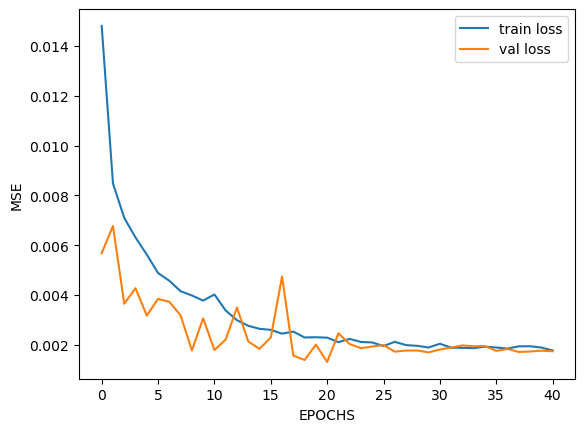

In [128]:
plt.plot(train_loss_per_epoch[1:])
plt.plot(val_loss_per_epoch[1:])
plt.legend(['train loss','val loss'])
plt.xlabel('EPOCHS')
plt.ylabel('MSE')

In [129]:
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)        

In [130]:
winrate(y_val.reshape(-1,), predictions1.reshape(-1,))

0.6791237113402062

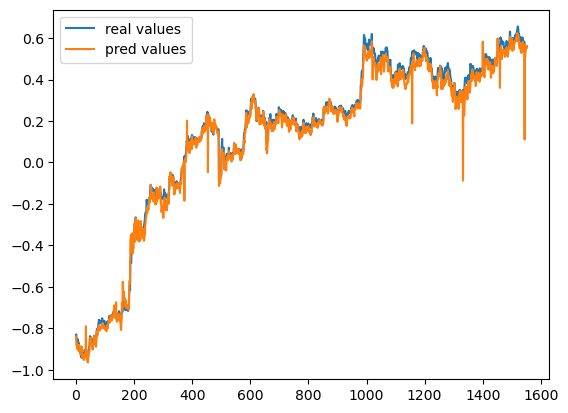

In [131]:
plt.plot(y_val[:])
plt.plot(predictions1[:])
plt.legend(['real values','pred values'])

Text(0, 0.5, 'WINRATE')

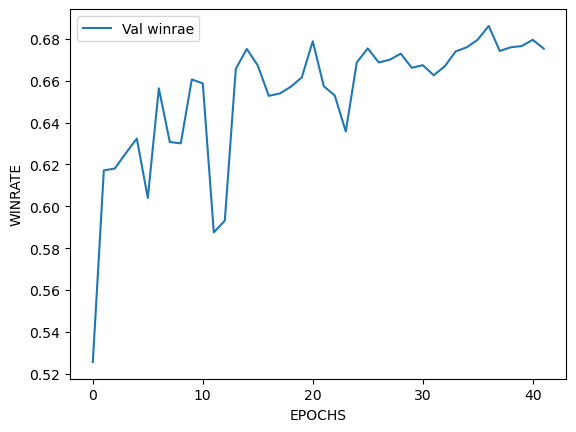

In [132]:
#plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Val winrae'])
plt.xlabel('EPOCHS')
plt.ylabel('WINRATE')

In [133]:
predictions1 = scaler_star.inverse_transform(predictions1.reshape(-1,1))

In [134]:
y_val = scaler_star.inverse_transform(y_val)

In [135]:
criterion(torch.Tensor(y_val),torch.Tensor(predictions1)).item()

8.519936561584473

In [136]:
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)

model.eval()
predictions2 = []
with torch.no_grad():
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions2.extend(outputs.squeeze().tolist())
predictions2 = np.array(predictions2)

In [137]:
winrate(y_train.reshape(-1,), predictions2.reshape(-1,))

0.713232650125854

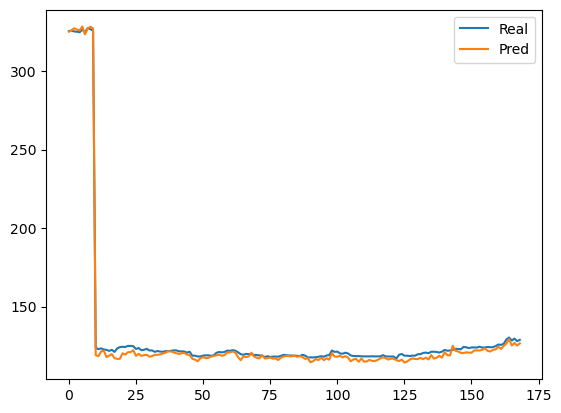

In [142]:
plt.plot(y_train[4000:4169])
plt.plot(predictions2[4000:4169])
plt.legend(['Real','Pred'])

In [139]:
y_train = scaler_star.inverse_transform(y_train)

In [140]:
predictions2 = scaler_star.inverse_transform(predictions2.reshape(-1,1))

In [141]:
criterion(torch.Tensor(y_train), torch.Tensor(predictions2))

tensor(3.3980)

In [143]:
torch.save(model.state_dict(), f'ЧВЕСА/[512,8,1,0.1]TRANS(ENC) (M F=TI) 1D|W=0.6791, TL=3.3980 VL=4.5199' )